# Cleaning data and the skies


## Executive Summary:
This notebook presents an analytical overview of ozone pollution across California using state-level air monitoring data. After cleaning and preprocessing the raw dataset, I conducted statistical and geospatial analyses to identify when and where ozone concentrations exceed safe levels.
# Recommendations:
1. Use homogeneous methods to measure ozone concentration as that may affect readings.
2. Weekday emissions are 0.9% higher than weekend emissions indicating the role of NOx from burning fossil fuels and VOCs emitted from cars.


In [34]:
import pandas as pd
import numpy as np
ozone = pd.read_csv('data/ozone.csv')

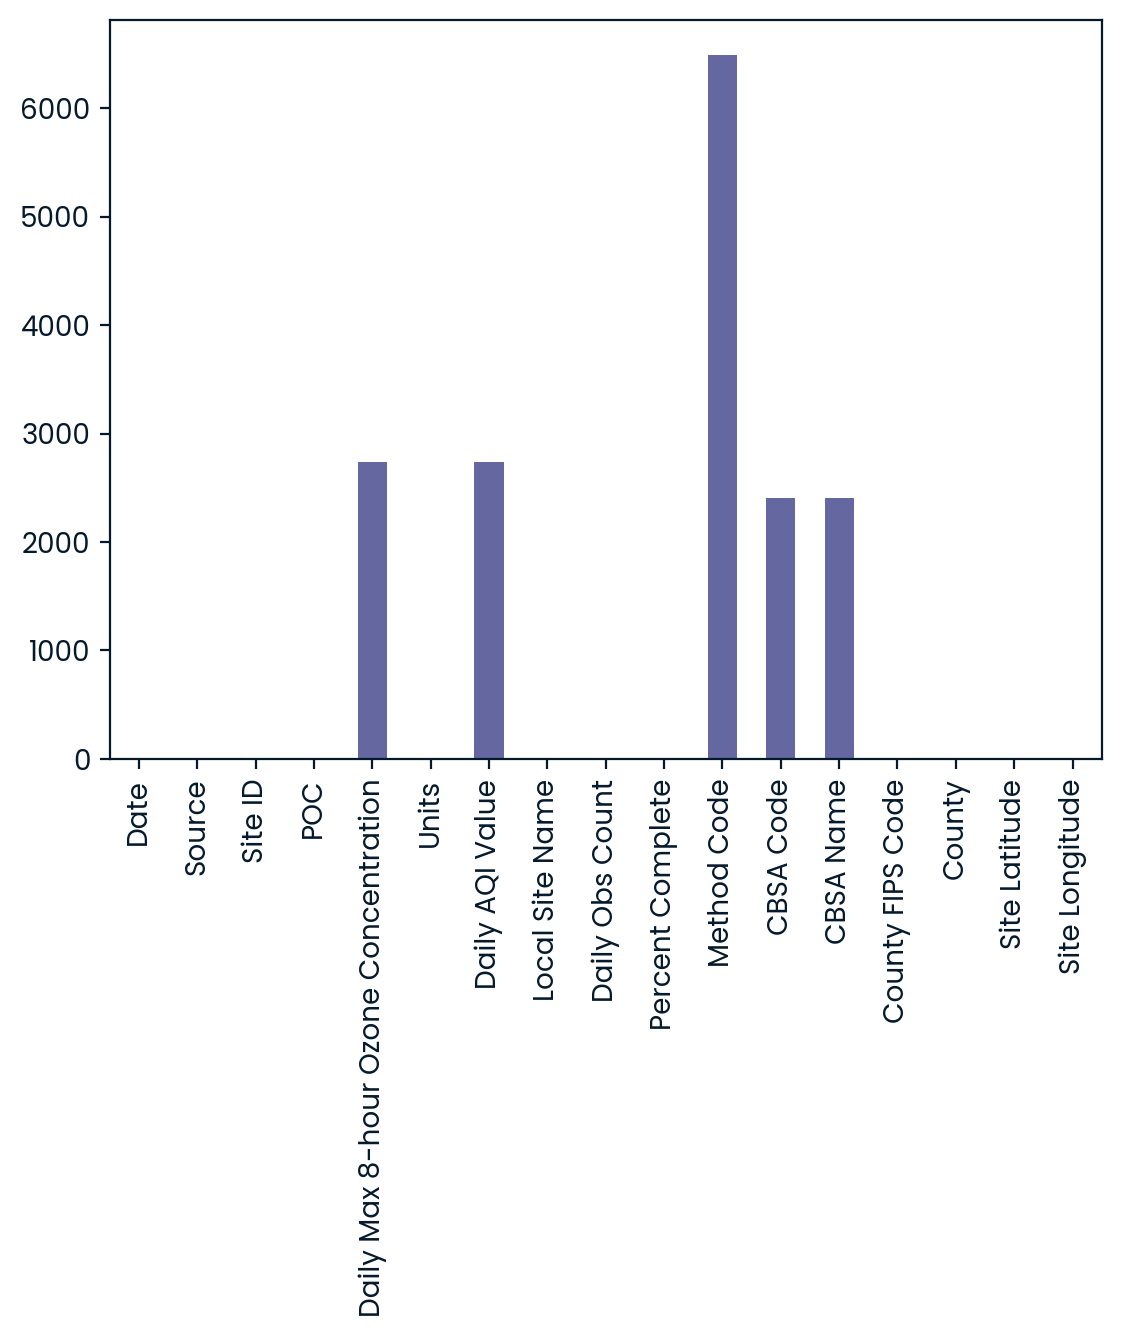

In [35]:
import matplotlib.pyplot as plt

#plotting number of nulls in each column
ozone.isna().sum().plot(kind = "bar")
plt.show()

In [36]:
#Date is an object type so converting it to datetime for better handling
ozone["Cleaned Date"] = pd.to_datetime(ozone["Date"], infer_datetime_format=True, errors='coerce')

Going through the CSV file, the data from this point onwards is not present in any particular order and needs to be ordered with the previous data. But because there is no order, we cannot give a correct date to /2024 data present this point forth, hence I drop these rows.

In [37]:
indexDate = ozone[(ozone.index>=54259) & (ozone["Cleaned Date"] == "2024-01-01")].index
ozone.drop(indexDate, inplace=True)
def pure_vectorized_correction(df, date_col="Cleaned Date", target_date="2024-01-01"):
    
    # Convert to datetime
    df[date_col] = pd.to_datetime(df[date_col])
    target_dt = pd.to_datetime(target_date)
    
    # Create groups of consecutive target dates
    is_target = df[date_col] == target_dt
    
    # Create group identifiers for consecutive sequences
    group_changes = (is_target != is_target.shift(1)).cumsum()

    group_info = pd.DataFrame({
        'date': df[date_col],
        'is_target': is_target,
        'group': group_changes
    })

    # For each group of consecutive target dates, find the correction
    def correct_group(group_df):
        if not group_df['is_target'].iloc[0]:
            return  # No correction needed for non-target groups
        
        group_size = len(group_df)
        
        # Find the next non-target date after this group
        last_idx = group_df.index[-1]
        if last_idx + 1 < len(df):
            next_date = df.loc[last_idx + 1, date_col]
            
            # Create corrected dates working backwards from next_date
            for i, (idx, row) in enumerate(group_df.iterrows()):
                days_back = group_size - i
                df.loc[idx, date_col] = next_date - pd.Timedelta(days=days_back)
    
    # Apply correction to each group 
    for group_id, group_data in group_info.groupby('group'):
        correct_group(group_data)
    
    return df

result = pure_vectorized_correction(ozone)

In [38]:
ozone = ozone.drop_duplicates()

In [39]:
# Filled in missing ozone and AQI values using linear inerpolation
ozone["Daily Max 8-hour Ozone Concentration"] = ozone["Daily Max 8-hour Ozone Concentration"].replace(0, np.nan).interpolate(method='linear')
ozone["Daily AQI Value"] = ozone["Daily AQI Value"].replace(0, np.nan).interpolate(method='linear')

ozone["Method Code"] = ozone.groupby("Local Site Name")["Method Code"].transform(
    lambda x: x.fillna(method='ffill').fillna(method='bfill')
)

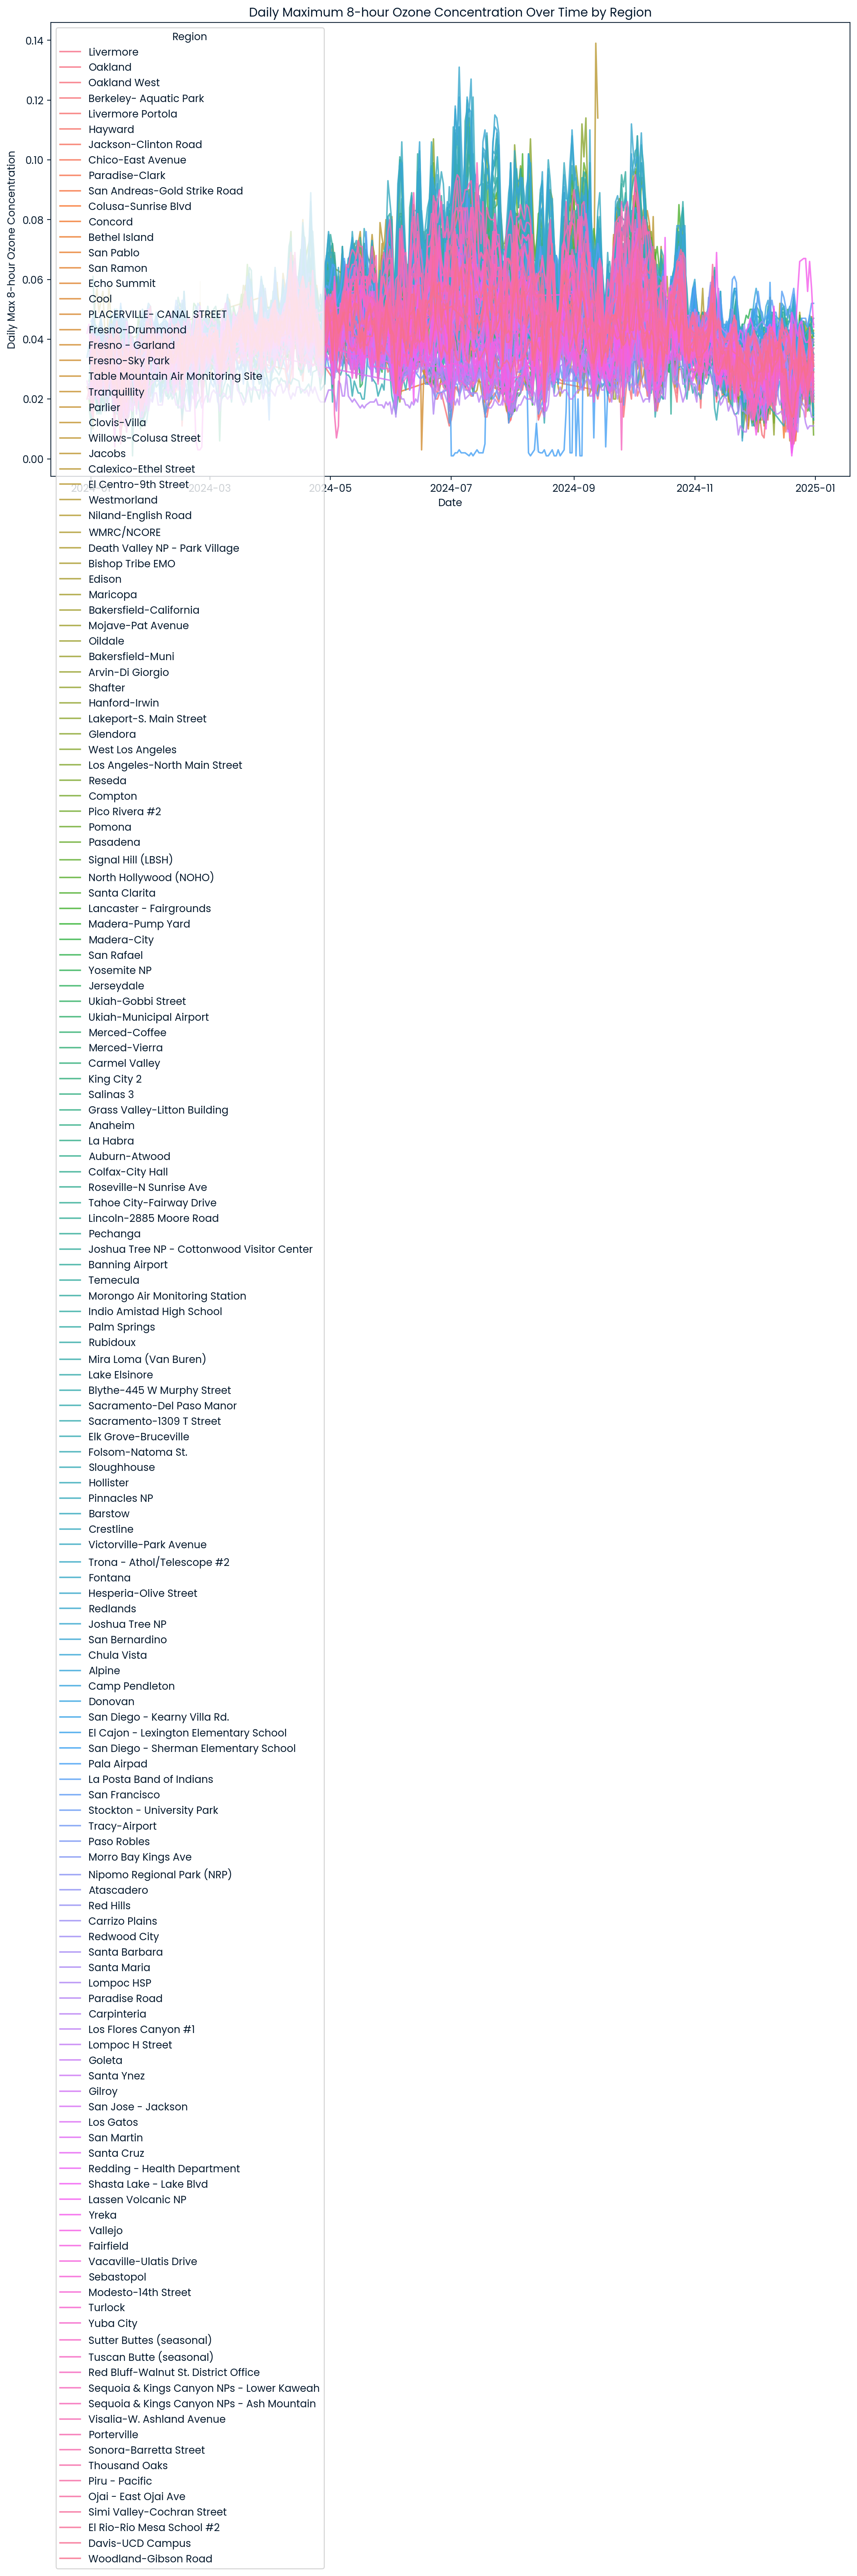

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the daily maximum 8-hour ozone concentration over time for each region
plt.figure(figsize=(14, 8))
sns.lineplot(data=ozone, x='Cleaned Date', y='Daily Max 8-hour Ozone Concentration', hue='Local Site Name', alpha = 0.8)
plt.title('Daily Maximum 8-hour Ozone Concentration Over Time by Region')
plt.xlabel('Date')
plt.ylabel('Daily Max 8-hour Ozone Concentration')
plt.legend(title='Region')
plt.show()

In [30]:
# Analyzing areas with consistently high ozone concentrations
# Grouping by Local Site Name and calculating the mean and standard deviation of the Daily Max 8-hour Ozone Concentration
ozone_stats = ozone.groupby("Local Site Name")["Daily Max 8-hour Ozone Concentration"].agg(['mean', 'std']).reset_index()
ozone_stats = ozone_stats.sort_values(by='mean', ascending=False)

# Displaying the statistics
ozone_stats

Local Site Name      mean       std
130  Sequoia & Kings Canyon NPs - Lower Kaweah  0.060767  0.012546
26                                   Crestline  0.059669  0.020188
105                                   Redlands  0.059307  0.023996
79              Morongo Air Monitoring Station  0.058775  0.017885
114                             San Bernardino  0.058327  0.023726
..                                         ...       ...       ...
117                              San Francisco  0.028182  0.006154
35                        Elk Grove-Bruceville  0.026619  0.007932
74                               Merced-Coffee  0.026000  0.004899
9                       Berkeley- Aquatic Park  0.025000  0.007285
16                                 Carpinteria  0.020793  0.004210

[162 rows x 3 columns]

In [31]:
# Analyzing if different methods report different ozone levels
# Grouping by Method Code and calculating the mean and standard deviation of the Daily Max 8-hour Ozone Concentration
method_stats = ozone.groupby("Method Code")["Daily Max 8-hour Ozone Concentration"].agg(['mean', 'std']).reset_index()
method_stats = method_stats.sort_values(by='mean', ascending=False)

# Displaying the statistics
method_stats

Method Code      mean       std
1         53.0  0.059805  0.016869
3        199.0  0.044825  0.016279
2         87.0  0.044730  0.014826
0         47.0  0.039322  0.011595

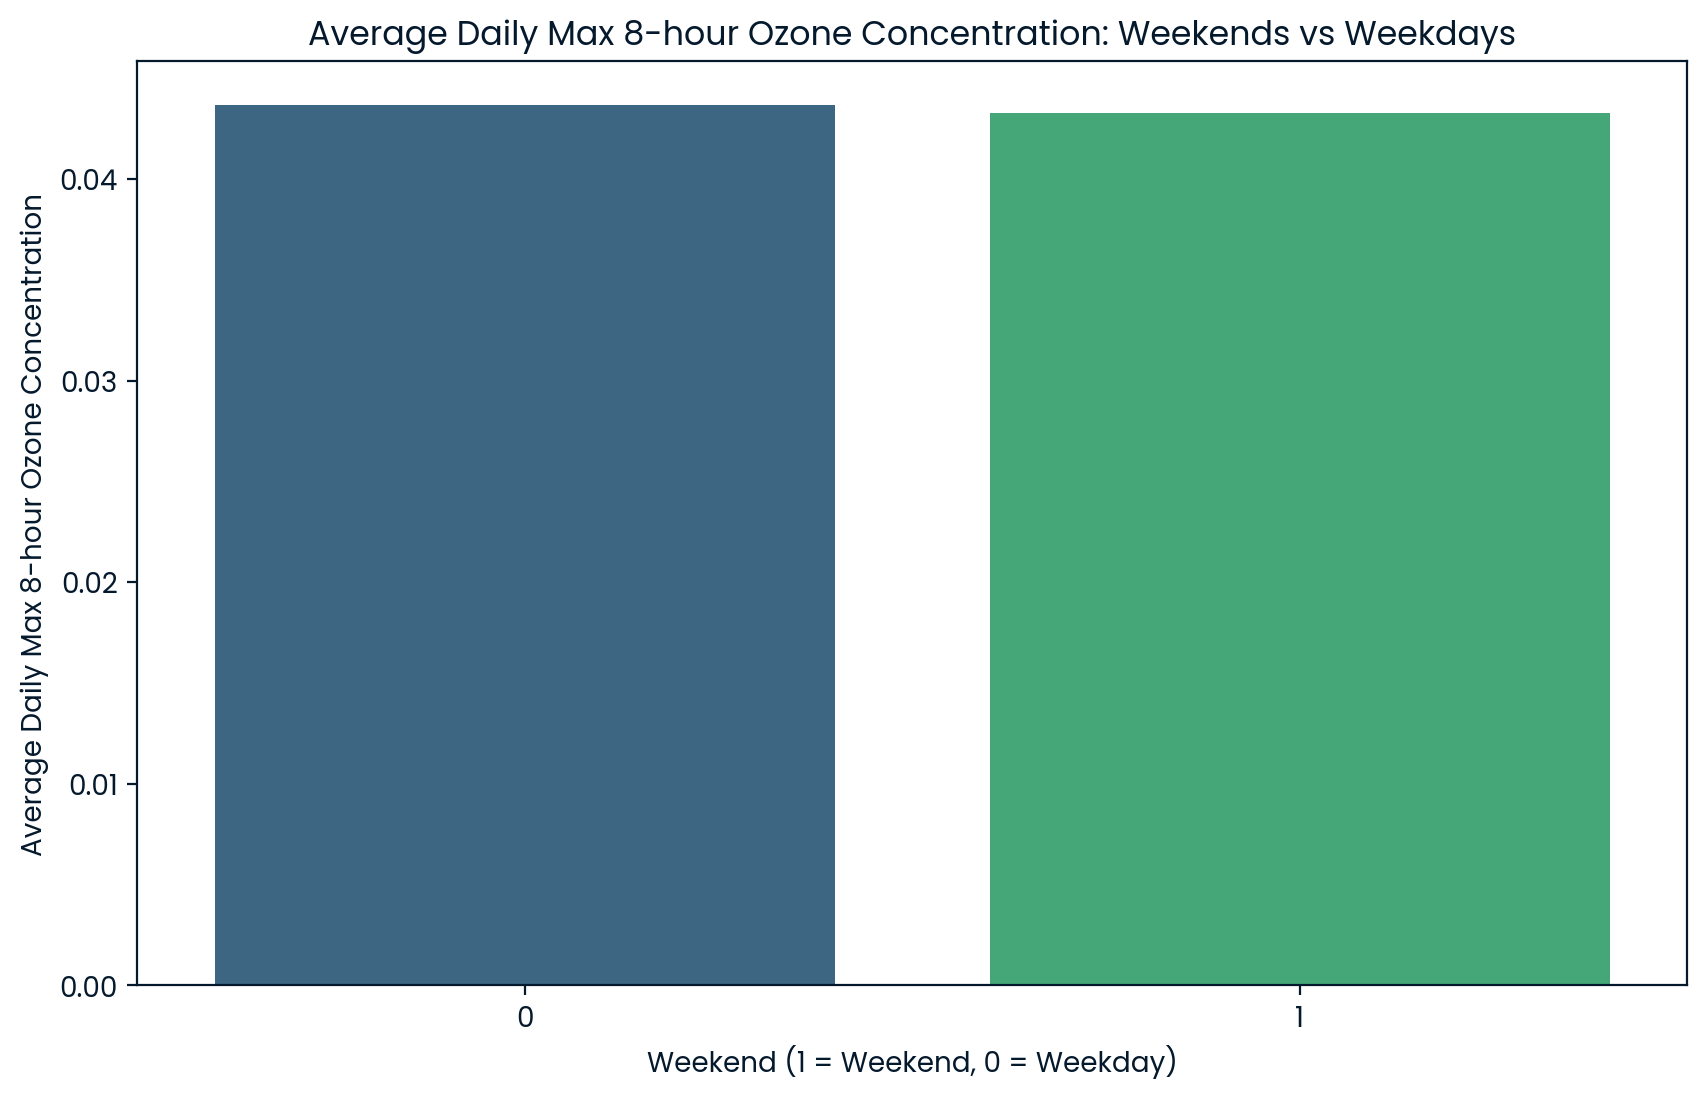

In [33]:
# Adding a column to indicate whether the day is a weekend or a weekday
ozone['Day of Week'] = ozone['Cleaned Date'].dt.dayofweek
ozone['Weekend'] = ozone['Day of Week'].apply(lambda x: 1 if x >= 5 else 0)

# Grouping by Weekend and calculating the mean and standard deviation of the Daily Max 8-hour Ozone Concentration
weekend_stats = ozone.groupby("Weekend")["Daily Max 8-hour Ozone Concentration"].agg(['mean', 'std']).reset_index()

# Displaying the statistics
weekend_stats

# Plotting the average ozone concentration for weekends vs weekdays
plt.figure(figsize=(10, 6))
sns.barplot(data=weekend_stats, x='Weekend', y='mean', palette='viridis')
plt.title('Average Daily Max 8-hour Ozone Concentration: Weekends vs Weekdays')
plt.xlabel('Weekend (1 = Weekend, 0 = Weekday)')
plt.ylabel('Average Daily Max 8-hour Ozone Concentration')
plt.show()

In [43]:
import plotly.express as px

# Load your DataFrame (replace this with your actual data load)
# ozone = pd.read_csv("your_file.csv")

# Simplify and prepare data
ozone = ozone.rename(columns={
    "Cleaned Date": "date",
    "Site Latitude": "lat",
    "Site Longitude": "lon",
    "Daily Max 8-hour Ozone Concentration": "ozone_8hr_max"
})
ozone["date"] = pd.to_datetime(ozone["date"])

# Optional: Filter out missing or extreme values
ozone = ozone.dropna(subset=["ozone_8hr_max", "lat", "lon"])
ozone = ozone[ozone["ozone_8hr_max"] < 0.2]  # filter extreme outliers if needed

# Create animated scatter map
fig = px.scatter_geo(
    ozone,
    lat="lat",
    lon="lon",
    color="ozone_8hr_max",
    animation_frame=ozone["date"].dt.strftime('%Y-%m-%d'),
    projection="natural earth",
    color_continuous_scale="YlOrRd",
    title="Daily Max 8-hour Ozone Concentration Over Time",
    hover_name="Local Site Name",
    size_max=15,
    opacity=0.7,
)

fig.update_geos(
    fitbounds="locations",  # Automatically fit the markers
    lataxis_range=[32, 42.5],  # California latitude range
    lonaxis_range=[-125, -113],  # California longitude range
)

fig.update_layout(geo=dict(showland=True, landcolor="rgb(217, 217, 217)"),
                  margin={"r":0,"t":30,"l":0,"b":0})

fig.show()
